### Presenter details

Georgia Tsambos (`g.tsambos` at `gmail.com`) is a graduating PhD student in statistical genetics at the University of Melbourne, Australia, and an incoming postdoc in the Kern/Ralph co-lab at the University of Oregon, and Kelley Harris' lab at the University of Washington, USA.

(Info about Yan, Jerome or other contributors?


### Sharing these notebooks


These materials were designed for the [2022 WORKSHOP ON POPULATION AND SPECIATION GENOMICS](http://evomics.org/2022-workshop-on-population-and-speciation-genomics-cesky-krumlov/) in Český Krumlov. They may be re-used, but please say where you got them from! [Here](https://github.com/gtsambos/2022-ts-workshops) is a link to the public GitHub repository that holds these notebooks.

### Plan for the day

At each location in the genome,
a distinct genealogical tree defines the historical relationship between the present-day members of a group and their ancestors.
Tree sequences are an efficient encoding of these \emph{gene genealogies}.
They were originally defined in \cite{Kelleher2016} for the purposes of genetic simulation,
but have since found many other uses

9am – 12pm session:
 
 1. Introduction
 2. Simulation 1

2pm – 5pm session:
 
 3. Simulation 2
 4. Analysis

7pm  – 10pm session:
 
 5. Inference
 6. Advanced topics and helper session


### How to use Jupyter notebooks

Click any cell to edit its code, then press SHIFT + ENTER to execute it. Try it here!

In [4]:
print("My favourite number is", 6+7)

My favourite number is 13


# Simulation, analysis and inference with tree sequence software

## Why tree sequences?

Genetic sequences are BIG and VERY REPETITIVE:

```
   ...GTAACGCGATAAGAGATTAGCCCAAAAACACAGACATGGAAATAGCGTA...
   ...GTAACGCGATAAGAGATTAGCCCAAAAACACAGACATGGAAATAGCGTA...
   ...GTAACGCGATAAGATATTAGCCCAAAAACACAGACATGGAAATAGCGTA...
   ...GTAACGCGATAAGATATTAGCCCAAAAACACAGACATGGAAATAGCGTA...
   ...GTAACGCGATAAGATATTAGCCCAAAAACACAGACATGGAAATAGCGTA...
   ...GTAACGCGATAAGATATTAGCCCAAAAACACAGACATGGTAATAGCGTA...
   ...GTAACGCGATAAGATATTAGCCCAAAAACACAGACATGGTAATAGCGTA...
```
   
Because of this, you are probably used to storing your data in a compressed format, and decompressing it only when you need to perform analyses or query the data. Doing this can be time-consuming and computationally expensive, however.

### The key idea

Common haplotypes in a sample are often simply a consequence of some common history. So if we know this history (as we always do in simulations!), storing it directly is often more convenient and efficient than storing the raw haplotypes.
A tree sequence is an encoding of a complete genealogy for a sample of chromosomes at each chromosomal location [1]. They offer a few benefits to population geneticists compared with traditional genetic file formats:




### The key benefits

File size

They can store large simulated datasets extremely compactly. (Often >100 of times smaller than VCFs for real-sized datasets!)

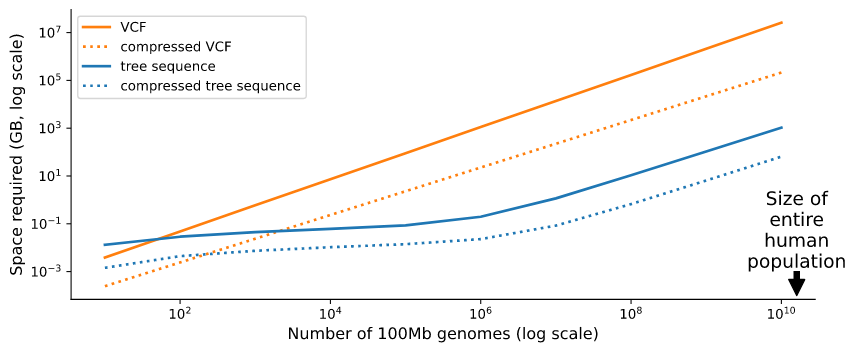

Computation

As they hold rich detail about the history of the sample, many important processes can be observed directly from the tree structure. So a tree sequence is often more informative than raw genotype/haplotype data, even though it is also more compact.

They can be queried and modified extremely quickly. In later workshops we will see that this enables quick calculation of many important population statistics.

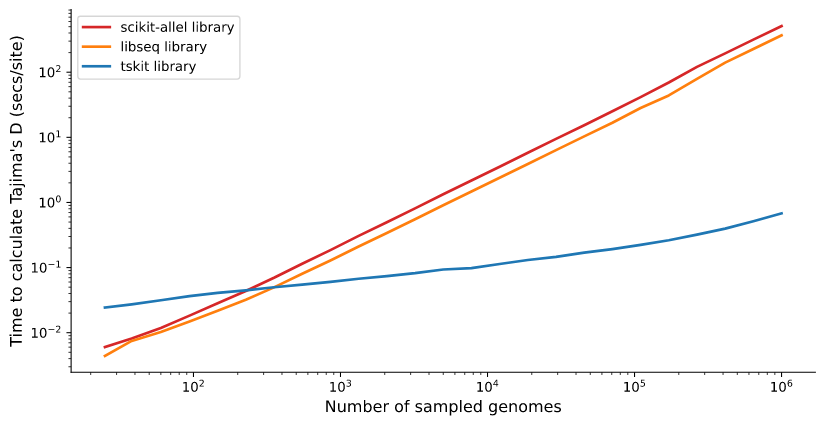

Not simply making biobank-sized analyses possible, but also - an exploratory tool that makes powerful analyses on normal-sized datasets more accessible.

## Trees

At a single nucleotide base, the genealogy of a sample at can be represented by a single tree.

The tree consists of nodes, which represent the alleles held by different chromosomes in the history of the sample, and edges, which represent genealogical relationships between the alleles.

Suppose we have a sample of 4 alleles, each from a different DNA sequence, and we wish to understand their history. We could represent this history with a tree like this one:

<img src="pics/worksheet1-tree.png" width="250" height="250">

The 4 sample nodes are those labelled 0 - 3 at the leaves of the tree. The other nodes are ancestral nodes: these are the alleles held by individuals that are ancestral to the sample.

The height of the nodes in the tree indicates the age of the node, and an edge joining a pair of nodes is used to indicate that the allele of the lower node is descended from the allele of the upper node.

## Tree sequences

The sample history encoded by a tree at a single base will typically also apply to some interval of neighbouring bases. However, due to recombinations in the history of the sample, the genealogy will typically be different at more distant locations on the chromosome, and so must be represented by a different tree. Thus, the history of a sample of sequences can be encoded in a sequence of trees - a tree sequence!

<img src="pics/worksheet1-treesequence.png" width="650" height="650">

The endpoints of the intervals are the locations where recombination has occurred in the history of the sample.

Notice that the adjacent trees look very similar to each other. This makes sense: each recombination should correspond to a single "tree edit" (or "subtree-prune-and-regraft" operation). Because these recombinations are specific to particular lineages, many genealogical relationships are unaffected by a given recombination. This means that topological features are often shared over many neighbouring trees.


## Tables and tree sequences

It turns out that each tree sequence object can be entirely specified by a set of tables. Instead of storing each tree individually, each individual topological feature is stored as a row in a relevant table.

Our example tree sequence can be represented with the following NodeTable and EdgeTable:

<img src="pics/worksheet1-tables.png" width="550" height="550">

There are other tables like Mutations, Sites, Populations, etc. that we will see later in this workshop.

Any topological feature that is common to several trees must only be recorded once in the corresponding collection of tables. For instance, all of the trees in our example tree sequence have an edge joining nodes 2 and 6, and this edge is recorded just once in the table.

(picture?)

This succinctness is one of main reasons why the tree sequence format is so compact!


Exercise: Can you modify the following Table Collection until the corresponding tree sequence looks like the one in this plot?

<img src="pics/worksheet1-pic-for-example.png" width="400" height="400">

In [1]:
import io
from IPython.display import SVG
import tskit

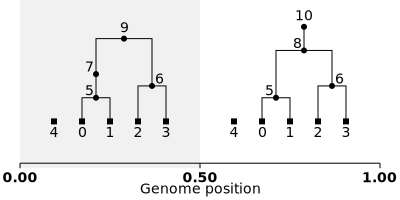

In [8]:
# Modify this code.
nodes_ex = io.StringIO("""\
id      is_sample   population      time
0       1       0               0.0
1       1       0               0.0
2       1       0               0.0
3       1       0               0.0
4       1       0               0.0
5       0       0               1.0
6       0       0               1.5
7       0       0               2.0
8       0       0               3.0
9       0       0               3.5
10      0       0               4.0
""")
edges_ex = io.StringIO("""\
id      left            right           parent  child
0       0.00000000      1.00000000      5       0
1       0.00000000      1.00000000      5       1
2       0.00000000      1.00000000      6       2
3       0.00000000      1.00000000      6       3
4       0.00000000      0.50000000      7       5
5       0.50000000      1.00000000      8       5
6       0.50000000      1.00000000      8       6
7       0.00000000      0.50000000      9       6
8       0.00000000      0.50000000      9       7
9       0.50000000      1.00000000      10      8
""")

# Load the tree sequence.
ts_ex = tskit.load_text(nodes=nodes_ex, edges=edges_ex, strict=False)

# Test by plotting it.
SVG(ts_ex.draw_svg())

## Mutations and variation

Variation is a consequence of mutations in the history of the sample. Thus, by adding some information about mutations to our tree sequences, we can use them to encode full haplotype data for each of our samples.

We need to store the genomic location of each variant site, as well as the lineage of the tree affected by the mutation. (This corresponds to an edge in the tree sequence). The subsample of haplotypes with the mutated type is simply the subset of nodes in the part of the tree that descends from the mutation.

<img src="pics/worksheet1-ts-with-muts.png" width="550" height="550">

(Mention -- variation does not need to be SNPs, as in the picture.)

This information is encoded with two extra tables: a site table showing the locations of the variant sites, and a mutations table showing the lineage of the tree affected by the mutation.

<img src="pics/worksheet1-tables-mut-highlight.png" width="700" height="700">

The mutation and alleles highlighted in pink correspond to the highlighted rows of the site and mutation tables.

Note that even if we had 400 or 400 000 samples, we would still only need two rows to store information about the alleles held by the samples at this position!


## The tskit package

Here's a tree sequence file corresponding to our example above. By default, the draw method will plot each mutation on the relevant edge of the relevant tree.


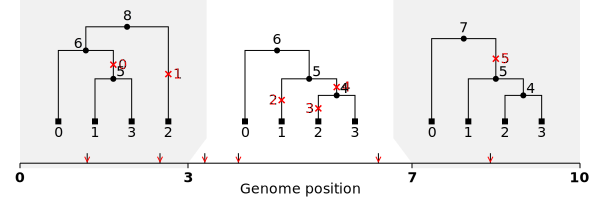

In [12]:
ts = tskit.load("example-2.trees")
SVG(ts.draw_svg())

Brief summary:
 - individual tables
 - number of items in each tables
 - iterating through items

In [13]:
ts

In [14]:
ts.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,5,nan,1,-1,b''
1,1,2,nan,1,-1,b''
2,2,1,nan,1,-1,b''
3,3,2,nan,1,-1,b''
4,4,4,nan,1,-1,b''
5,5,5,nan,1,-1,b''


In [15]:
ts.num_mutations

6

In [17]:
for m in ts.mutations():
    print(m)

Mutation(id=0, site=0, node=5, derived_state='1', parent=-1, metadata=b'', time=nan)
Mutation(id=1, site=1, node=2, derived_state='1', parent=-1, metadata=b'', time=nan)
Mutation(id=2, site=2, node=1, derived_state='1', parent=-1, metadata=b'', time=nan)
Mutation(id=3, site=3, node=2, derived_state='1', parent=-1, metadata=b'', time=nan)
Mutation(id=4, site=4, node=4, derived_state='1', parent=-1, metadata=b'', time=nan)
Mutation(id=5, site=5, node=5, derived_state='1', parent=-1, metadata=b'', time=nan)


Also, sites

In [19]:
ts.num_sites

6

In [20]:
ts.tables.sites

id,position,ancestral_state,metadata
0,1.20000000,0,b''
1,2.50000000,0,b''
2,3.30000000,0,b''
3,3.90000000,0,b''
4,6.40000000,0,b''
5,8.40000000,0,b''


In [21]:
for s in ts.sites():
    print(s)

Site(id=0, position=1.2, ancestral_state='0', mutations=[Mutation(id=0, site=0, node=5, derived_state='1', parent=-1, metadata=b'', time=nan)], metadata=b'')
Site(id=1, position=2.5, ancestral_state='0', mutations=[Mutation(id=1, site=1, node=2, derived_state='1', parent=-1, metadata=b'', time=nan)], metadata=b'')
Site(id=2, position=3.3, ancestral_state='0', mutations=[Mutation(id=2, site=2, node=1, derived_state='1', parent=-1, metadata=b'', time=nan)], metadata=b'')
Site(id=3, position=3.9, ancestral_state='0', mutations=[Mutation(id=3, site=3, node=2, derived_state='1', parent=-1, metadata=b'', time=nan)], metadata=b'')
Site(id=4, position=6.4, ancestral_state='0', mutations=[Mutation(id=4, site=4, node=4, derived_state='1', parent=-1, metadata=b'', time=nan)], metadata=b'')
Site(id=5, position=8.4, ancestral_state='0', mutations=[Mutation(id=5, site=5, node=5, derived_state='1', parent=-1, metadata=b'', time=nan)], metadata=b'')


Exercise: use the syntax demonstrated above to look at all of the nodes in this toy tree sequence. 

In [18]:
# Modify this code.
print(ts.tables.mutations)
print(ts.num_mutations)
for m in ts.mutations():
    print(m)

╔══╤════╤════╤════╤═════════════╤══════╤════════╗
║id│site│node│time│derived_state│parent│metadata║
╠══╪════╪════╪════╪═════════════╪══════╪════════╣
║0 │   0│   5│ nan│            1│    -1│     b''║
║1 │   1│   2│ nan│            1│    -1│     b''║
║2 │   2│   1│ nan│            1│    -1│     b''║
║3 │   3│   2│ nan│            1│    -1│     b''║
║4 │   4│   4│ nan│            1│    -1│     b''║
║5 │   5│   5│ nan│            1│    -1│     b''║
╚══╧════╧════╧════╧═════════════╧══════╧════════╝

6
Mutation(id=0, site=0, node=5, derived_state='1', parent=-1, metadata=b'', time=nan)
Mutation(id=1, site=1, node=2, derived_state='1', parent=-1, metadata=b'', time=nan)
Mutation(id=2, site=2, node=1, derived_state='1', parent=-1, metadata=b'', time=nan)
Mutation(id=3, site=3, node=2, derived_state='1', parent=-1, metadata=b'', time=nan)
Mutation(id=4, site=4, node=4, derived_state='1', parent=-1, metadata=b'', time=nan)
Mutation(id=5, site=5, node=5, derived_state='1', parent=-1, metadata=b'

## Uses of tree sequences

(Turn this into something more presentable...)


When I began my PhD candidature in 2017, details of the tree sequence structure had only recently been published by Kelleher et al. [11], and there were very few methods making use of them. It has been exciting to follow the rapid uptake of tree sequences in the population genetics community since then. I summarise these developments in this section.

### Simulation

In population genetics, the models involved are often large and analytically intractable. Because of this, software that can simulate genomic data from these models are a key tool.
The tree sequence structure was originally designed for the msprime simulator [11, 14]. Early versions of msprime emulated the popular ms coalescent simulator [66], but it has since become a more flexible backwards-in-time simulator for various different models of genetic ancestry and mutation, and even for simplified models of selection.
Recent versions of the SLiM software [71] also produce tree sequence output. Due to their forwards-in-time construction, SLiM simulations are generally slower and more compu- tationally intensive than those produced with msprime, but they are able to incorporate a degree of ecological realism and fine detail that msprime cannot. However, the pyslim package [72] makes it possible to simulate tree sequences that are ‘stitched together’ from each of these simulators, allowing users to add a simpler model of ancient history generated under msprime to a more complicated model of recent history simulated under SLiM.
The inter-operability, efficiency and generality of msprime and SLiM make them of great utility in many applications. Indeed, there are now several other, more specialised, simulators that rely on msprime and SLiM under the hood, such as stdpopsim [17] and slendr [73].

### Inference

Since gene genealogies cannot be observed directly from genotypes, any analysis of real data requires a method to infer them. The most scaleable of these methods, tsinfer and tsdate [64, 15], are designed to be used together. The user first runs tsinfer on genotype data to obtain a tree sequence with estimated tree topologies at each genomic location. Next, they run tsdate to estimate the times of the nodes in this tree sequence. This method has been used to produce publicly available inferred tree sequences based on the UK Biobank [15, 58] for each human chromosome, as well as for the HGDP and 1000 Genomes datasets [16, 74].
The Relate software package also infers a sequence of marginal genealogical trees for genotype input, and returns them as tree sequence output [75]. However, Relate does not attempt to infer the shared identity of nodes across different trees. As a consequence, each tree in Relate output contains distinct ancestral nodes, and no edges are shared across multiple trees. For this reason, Relate cannot be used with the IBD methods presented in this thesis, and its inferred tree sequences are often many times larger than those inferred with tsinfer.
Various methods are able to infer ancestral recombination graphs in other formats [69, 76]. As discussed in Section 1.4.8, tree sequences may be a convenient way to store them. Of particular note is ARGinfer [77], which uses an augmented version of the tree sequence structure to perform MCMC sampling under a model of the coalescent with recombination.

### Population genetic analyses


Geneticists often describe their endeavours as an exploration into how particular evolu- tionary, biological and historical processes have impacted patterns of observed genetic variation [78]. However, it is in fact the gene genealogies that are directly impacted by these processes; any effects on observed variation are simply a projection of these impacts on the gene genealogy representing the present-day samples [79]. Now that we have effective methods for simulating and inferring these gene genealogies at scale, some focus has shifted to finding new ways of investigating questions of interest, assuming we have an explicit gene genealogy avaiilable. Some of these are inferential methods based on new statistics that make use of the information about times, ancestors and branches that are inherent in a gene genealogy. A recent preprint estimates various quantities relating to the spatial location and movement of ancestors in a genealogy [80]. Another method uses the branch information in these genealogies to derive new summaries of genetic relatedness that are more stable (i.e. lower variance) than more conventional summaries using genotypes only [81].

## Relationship to ARGs

Most of the current literature on gene genealogies names the objects of interest as ancestral recombination graphs (ARGs). However, this term has been used in many different ways since it was defined by Griffiths and Marjoram, inviting considerable confusion. See Baumdicker et al. for further discussion of this problem. In the tskit community, we use the term ARG to refer exclusively to a realisation of the coalescent process with recombination. Tree sequences provide a way to encode a relevant subset of the information in these ARGs.

Copy in plot from the msprime 1.0 paper that shows differences between ARGs and tree sequences.